In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [8]:
df_ajustado = pd.read_csv('Datos/Transformados/limpio.csv',index_col=0)

In [9]:
df_ajustado

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V
fecha,,,,,,,,,,,,,,,,,,,,,
2018-06-07,48.375000,183.300003,101.480003,368.529999,156.289993,132.910004,43.650002,126.959999,102.470001,NaN,...,43.439999,169.479996,171.463211,56.441569,100.879997,74.760002,75.760002,129.770004,248.979996,133.839996
2018-06-08,47.877500,184.300003,101.000000,369.500000,155.320007,133.529999,43.480000,126.440002,103.980003,NaN,...,43.950001,168.910004,172.734116,56.978761,101.629997,74.900002,77.180000,131.320007,250.679993,134.740005
2018-06-11,47.790000,184.610001,101.199997,370.940002,156.350000,133.979996,43.689999,127.559998,104.349998,NaN,...,44.130001,166.490005,171.505020,56.751135,101.050003,74.589996,77.529999,130.500000,253.779999,133.880000
2018-06-12,48.080000,185.070007,100.730003,370.619995,157.485000,136.259995,43.939999,127.080002,104.330002,NaN,...,44.410000,166.729996,171.337799,56.851292,101.309998,74.300000,77.239998,129.580002,253.580002,134.880000
2018-06-13,47.666250,183.679993,100.019997,363.850006,154.700000,136.500000,44.009998,127.070000,106.309998,NaN,...,44.180000,166.580002,171.312714,56.987864,100.849998,74.120000,76.470001,129.720001,252.869995,134.340000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,133.410000,240.950000,168.210000,250.570000,219.340000,243.770000,52.780000,107.140000,177.930000,63.11,...,54.390000,233.330000,193.260000,76.360000,266.690000,133.600000,133.020000,149.970000,398.870000,236.240000
2021-06-28,133.110000,242.680000,169.450000,248.380000,216.310000,241.870000,53.060000,107.300000,178.350000,63.29,...,54.320000,232.420000,194.750000,77.200000,265.020000,154.350000,134.920000,151.720000,404.950000,237.320000
2021-06-29,134.780000,242.840000,164.780000,239.960000,216.270000,244.570000,52.960000,103.990000,176.570000,62.90,...,54.260000,231.090000,196.500000,76.860000,268.720000,152.360000,135.320000,149.450000,401.460000,234.090000


**Cambios al dia**

C:\Users\lande\AppData\Local\Temp\ipykernel_19128\3640970676.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


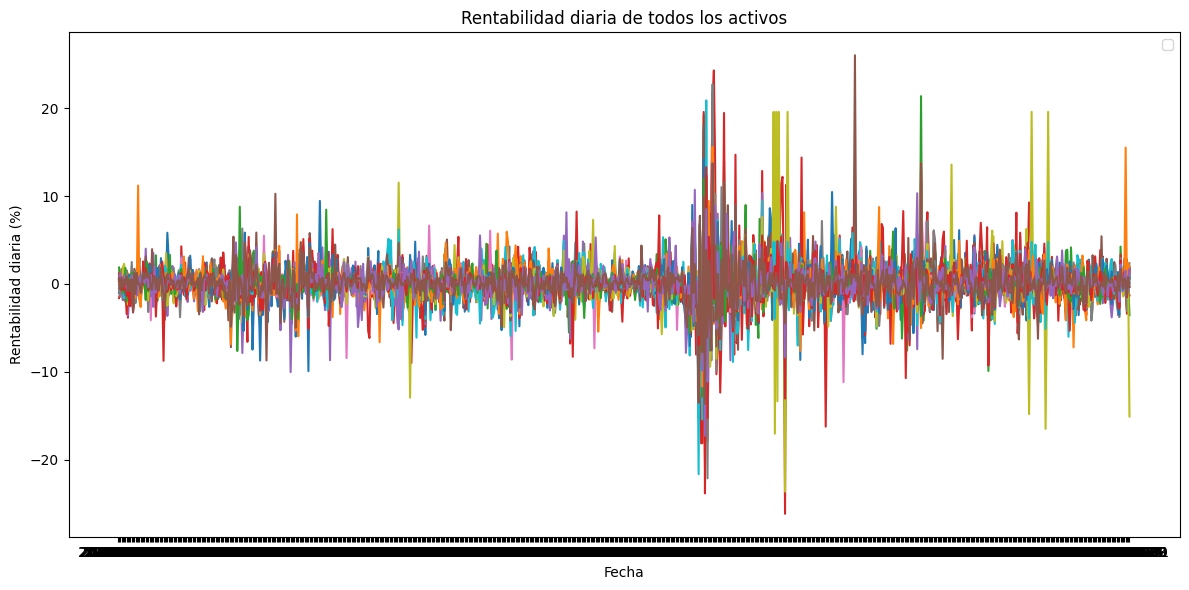

In [10]:
rentabilidades_diarias = df_ajustado.pct_change() * 100
plt.figure(figsize=(12,6))
for col in df_ajustado.columns:
    plt.plot(df_ajustado.index, rentabilidades_diarias[col])
plt.title('Rentabilidad diaria de todos los activos')
plt.xlabel('Fecha')
plt.ylabel('Rentabilidad diaria (%)')
plt.legend()
plt.tight_layout()
plt.show()

Define la función de **rentabilidad anualizada**:
$r_{periodo} = (1+r)^n -1$

In [11]:
def rentabilidad_anualizada(r_diaria, n=252):
    return (np.prod(1 + r_diaria) ** (n / len(r_diaria))) - 1

In [12]:
resultados = {}
for col in df_ajustado.columns:
    serie = df_ajustado[col].dropna()
    rent_diaria = rentabilidades_diarias[col].loc[serie.index].dropna()
    if len(serie) > 1 and len(rent_diaria) > 0:
        rent_media = rent_diaria.mean()
        rent_activa = (serie.iloc[-1] - serie.iloc[0]) / serie.iloc[0]
        r_diaria_decimal = rent_diaria / 100
        rent_anual = rentabilidad_anualizada(r_diaria_decimal, 252)
        resultados[col] = {
            'Rentabilidad media (%)': rent_media,
            'Rentabilidad activa (%)': rent_activa*100,
            'Rentabilidad anualizada (%)': rent_anual*100}
    else:
        resultados[col] = {'Rentabilidad media (%)': np.nan, 'Rentabilidad activa (%)': np.nan, 'Rentabilidad anualizada (%)': np.nan}
df_resultados = pd.DataFrame(resultados).T
df_resultados

,Rentabilidad media (%),Rentabilidad activa (%),Rentabilidad anualizada (%)
AAPL,0.154007,183.762283,39.122608
AMGN,0.052188,34.697212,9.888621
AXP,0.094406,64.505318,17.068183
BA,0.009849,-34.949666,-12.727384
CAT,0.064315,38.658914,10.901711
CRM,0.105316,84.320208,21.360081
CSCO,0.043882,22.428400,6.615904
CVX,0.008269,-16.343730,-5.492919
DIS,0.090410,72.987208,18.946362
DOW,0.086902,27.510042,10.899013


In [13]:
vol_diaria = rentabilidades_diarias.std()
vol_anual = vol_diaria * np.sqrt(252)
df_volatilidad = pd.DataFrame({'Volatilidad diaria': vol_diaria, 'Volatilidad anualizada': vol_anual})
df_volatilidad

,Volatilidad diaria,Volatilidad anualizada
AAPL,2.138965,33.955017
AMGN,1.724462,27.374981
AXP,2.548340,40.453644
BA,3.555055,56.434753
CAT,2.151068,34.147149
CRM,2.403785,38.158907
CSCO,1.918137,30.449481
CVX,2.460578,39.060468
DIS,2.086761,33.126309
DOW,3.004605,47.696630


**Volatilidad anualizada**: $\sigma*\sqrt(n)$

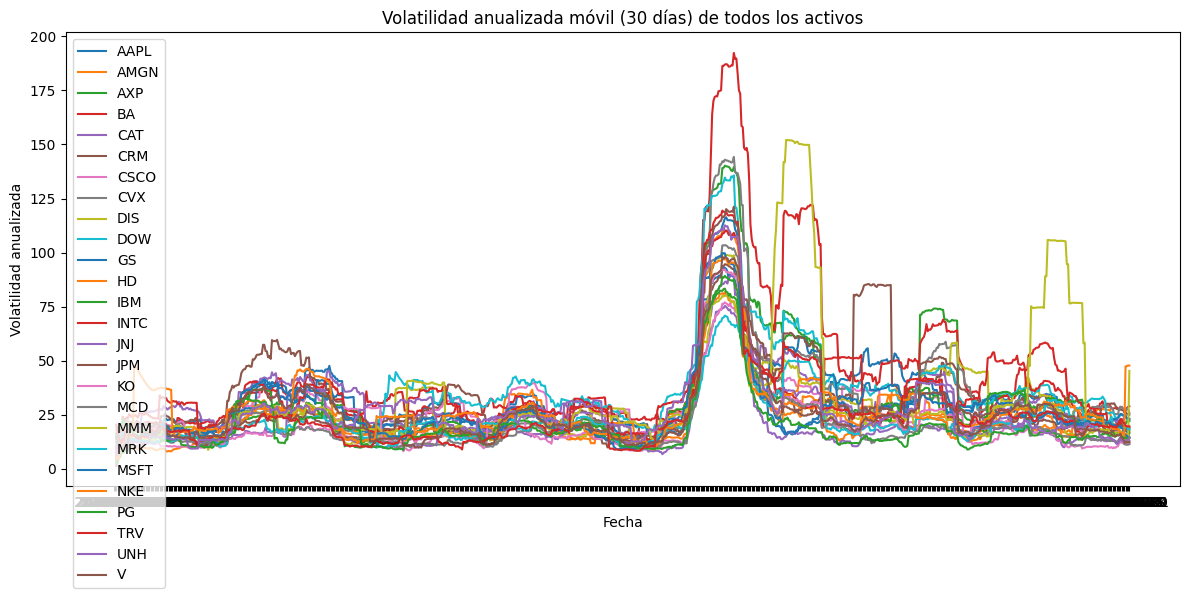

In [14]:
vol_30d = rentabilidades_diarias.rolling(window=30, min_periods=1).std() * np.sqrt(252)
plt.figure(figsize=(12,6))
for col in df_ajustado.columns:
    plt.plot(df_ajustado.index, vol_30d[col], label=col)
plt.title('Volatilidad anualizada móvil (30 días) de todos los activos')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad anualizada')
plt.legend()
plt.tight_layout()
plt.show()

**Ratio de Sharpe**: $S_h = \frac{r-r_f}{\sigma}$

In [15]:
rf = 0.025
sharpe = {}
for col in df_ajustado.columns:
    vol_anual_col = vol_anual[col] if col in vol_anual else np.nan
    rent_anual_col = df_resultados.loc[col, 'Rentabilidad anualizada (%)'] if col in df_resultados.index else np.nan
    if not np.isnan(vol_anual_col) and not np.isnan(rent_anual_col) and vol_anual_col != 0:
        sharpe[col] = (rent_anual_col/100 - rf) / vol_anual_col
    else:
        sharpe[col] = np.nan
df_sharpe = pd.DataFrame({'Sharpe': sharpe})
df_sharpe

,Sharpe
AAPL,0.010786
AMGN,0.002699
AXP,0.003601
BA,-0.002698
CAT,0.002460
CRM,0.004943
CSCO,0.001352
CVX,-0.002046
DIS,0.004965
DOW,0.001761


$Drawdown_i = \frac{p_i}{p_{max}}$

$Max-drawdown = min(drawdown_i)_n$

In [16]:
max_drawdown = {}
for col in df_ajustado.columns:
    serie = df_ajustado[col].dropna()
    if len(serie) > 1:
        max_close = serie.cummax()
        drawdown = serie / max_close - 1
        max_drawdown[col] = drawdown.min()
    else:
        max_drawdown[col] = np.nan
df_drawdown = pd.DataFrame({'Max Drawdown': max_drawdown})
df_drawdown

,Max Drawdown
AAPL,-0.383931
AMGN,-0.250658
AXP,-0.496385
BA,-0.784372
CAT,-0.419463
CRM,-0.357158
CSCO,-0.428079
CVX,-0.575843
DIS,-0.434450
DOW,-0.631552


C:\Users\lande\AppData\Local\Temp\ipykernel_19128\348396274.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


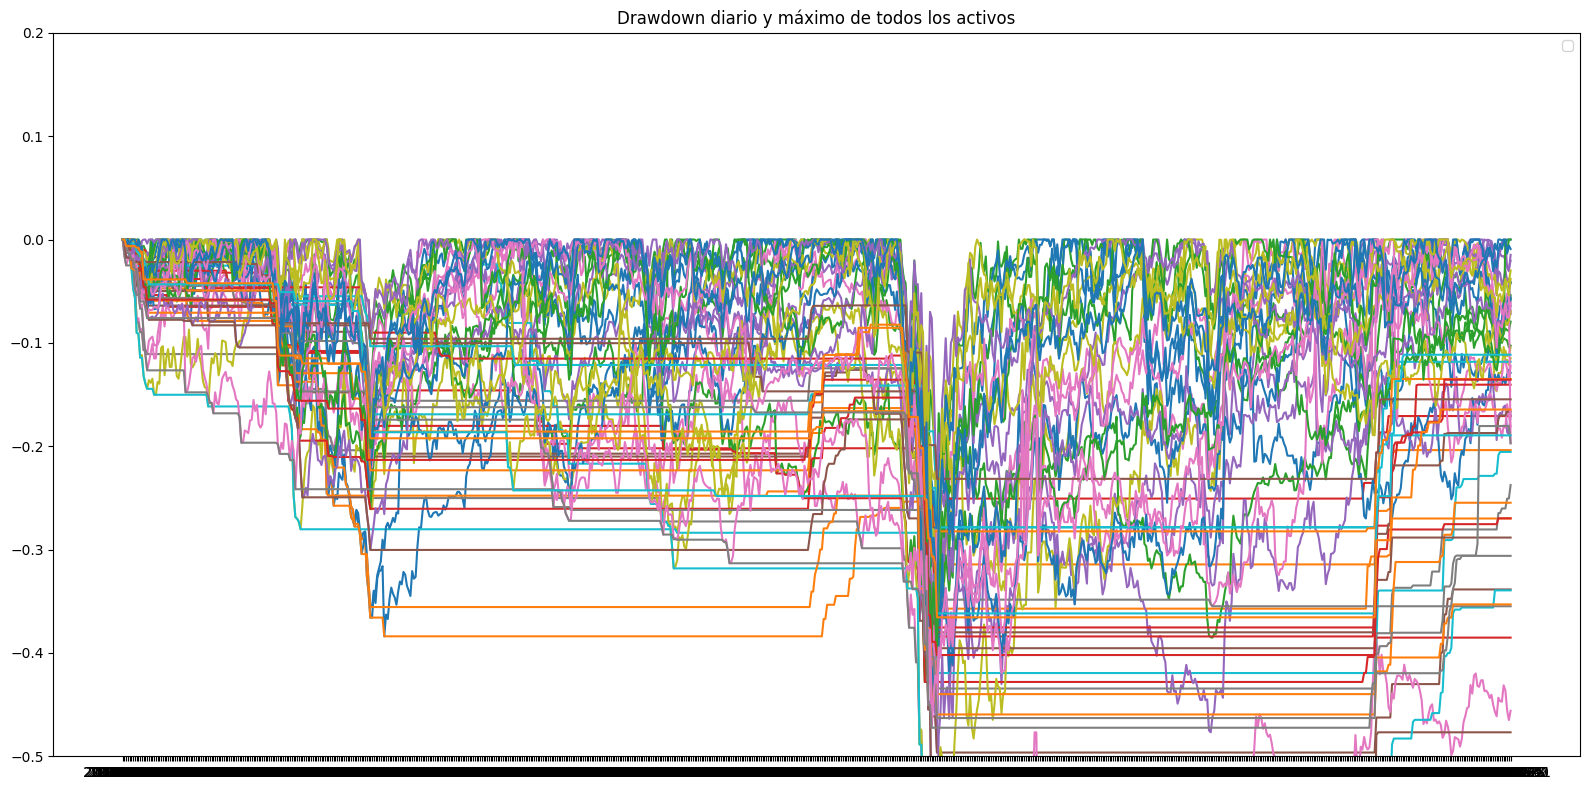

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
for col in df_ajustado.columns:
    serie = df_ajustado[col].dropna()
    if len(serie) > 1:
        max_close = serie.cummax()
        daily_drawdown = serie / max_close - 1
        max_daily_drawdown = daily_drawdown.rolling(window=252, min_periods=1).min()
        ax.plot(serie.index, daily_drawdown)
        ax.plot(serie.index, max_daily_drawdown)
ax.set_ylim(-0.5, 0.2)
ax.legend()
plt.title('Drawdown diario y máximo de todos los activos')
plt.tight_layout()
plt.show()